This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fconference-ia/HEAD?urlpath=lab/tree/notebooks5_support_vector_machine/)

# Handwritten digits recognition

This is a continuation of the notebook done previously during the lab on Discriminant Analysis.
 
Remember that we aim to recognize handwritten digits in digital images.
After normalization (see [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/zip.info.txt) for more details on these data, which are taken from zip codes on US postal envelopes), the resulting images are composed of $16 \times 16$ pixels, each pixel being quantified in gray levels in the interval $[- 1.1]$.
Thus, we  have $X \in [-1,1]^{256}$, i.e $p = 256$, and $Y \in \{0,1, \ldots, 9 \}$.

The code cells below allow to
- [Display some images from each class](#Display-some-digits)
- [Get the results for LDA](#Recap-on-Regularized-linear-discriminant-analysis-results)
- [Focus on binary classification task for a couple of digits](#Binary-classification)
- [Use Non-Linear kernels](#Non-Linear-SVM)

### Load (full) data sets

In [1]:
# Import modules
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.io as spio

# Warning: put the data files in the notebook directory
data = spio.loadmat("zip_train_full.mat")
Xtrain = data["Xtrain_full"]
Ytrain = data["Ytrain_full"]
Xshape = Xtrain.shape
Ytrain = np.reshape(Ytrain, (Xshape[0],))
Yshape = Ytrain.shape

print("Xtrain is (n={},p={}) sized".format(Xshape[0], Xshape[1]))
print("Ytrain is a (n={},) sized vector of reponses".format(Yshape[0]))

data_test = spio.loadmat("zip_test_full.mat")
Xtest = data_test["Xtest_full"]
Ytest = data_test["Ytest_full"]
Ytest = np.reshape(Ytest, (Xtest.shape[0],))
print("Xtest is (n={},p={}) sized".format(Xtest.shape[0], Xtest.shape[1]))

Xtrain is (n=8250,p=256) sized
Ytrain is a (n=8250,) sized vector of reponses
Xtest is (n=2750,p=256) sized


### Display some digits

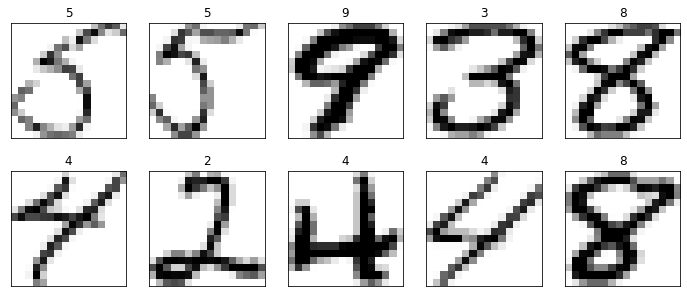

In [2]:
fig = plt.figure(figsize=(12, 5))  # to specify the size of the images
for i, ind in enumerate(np.random.choice(Xshape[0], 10)):
    fig.add_subplot(2, 5, i+1)
    mplot = plt.imshow(np.reshape(Xtrain[ind,:], (16, 16)), cmap="gray_r")
    plt.title(Ytrain[ind])
    mplot.axes.get_xaxis().set_visible(False)
    mplot.axes.get_yaxis().set_visible(False)

## Recap on Regularized *linear* discriminant analysis results

Here are the multiclass class results for (regularized) linear discriminant analysis

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Fit and test Regularized LDA
#qda = QDA(reg_param=.1)
lda = LDA(solver='lsqr', shrinkage='auto')
lda.fit(Xtrain, Ytrain)

y_hat = lda.predict(Xtest)
mcr_test = np.mean(Ytest != y_hat)

print("Regularized LDA test mcr: {:0.3f}".
          format(mcr_test))

Regularized LDA test mcr: 0.101


### Display the *confusion matrix*

The *confusion matrix* (see the [scikitlearn user guide](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix) for some examples) is a useful tool in supervised learning to evaluate classification accuracy. Quoting Wikipedia:
>Each column of the matrix represents the instances in a predicted class while each row represents the instances in an actual class (or vice versa, depending on the convention). The name stems from the fact that it makes it easy to see the confusion between two classes (i.e. commonly mislabeling one as another). 

In [4]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Ytest, y_hat) # y_hat is the auto regularized LDA prediction

array([[258,   2,   3,   1,   0,   3,   6,   0,   2,   0],
       [  1, 257,   0,   2,   4,   0,   0,   0,  11,   0],
       [  3,   7, 235,   3,   3,   4,   6,   6,   6,   2],
       [  4,   1,   6, 250,   0,   7,   1,   4,   1,   1],
       [  0,  10,   3,   0, 238,   0,   3,   1,   1,  19],
       [  3,   2,   1,  21,   2, 240,   1,   2,   2,   1],
       [  5,   5,   3,   0,   1,   2, 258,   0,   1,   0],
       [  0,   3,   0,   0,   2,   1,   0, 254,   2,  13],
       [  6,   7,   1,   6,   2,  14,   0,   0, 232,   7],
       [  0,   6,   0,   0,   8,   0,   0,   8,   2, 251]])

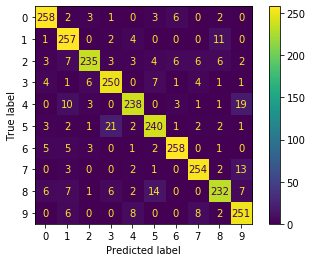

In [5]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lda, Xtest, Ytest)
plt.show() 

#### Questions:
- For regularized LDA, what are the the most common confusions between classes.

## Binary classification

We select in the following a couple of digits with the most confusions among predictions. 

In [6]:
# Select a couple of digits with the most confusions among predictions
digit_pair = [3, 5] 
sel_pair = np.logical_or(Ytrain == digit_pair[0], 
                         Ytrain == digit_pair[1])
X_train = Xtrain[ sel_pair ]
y_train = Ytrain[ sel_pair ]

sel_pair_test = np.logical_or(Ytest == digit_pair[0], 
                              Ytest == digit_pair[1])
X_test = Xtest[ sel_pair_test ]
y_test = Ytest[ sel_pair_test ]

We refit a LDA model anc compute its accuracy for this two-class dataset (remember that due do the global covariance matrix assumption in LDA, results should not be the same for the multiclass problem or for a particular binary one)

In [7]:
from time import time

# train the LDA model
start = time()
lda = LDA(solver='lsqr', shrinkage='auto')
lda.fit(X_train, y_train)
print("This took %0.3fs" % (time() - start))

y_pred = lda.predict(X_test)
mcr_test = np.mean(y_test != y_pred)

print("Regularized LDA mcr on the test set:: {:0.3f}".
          format(mcr_test))
confusion_matrix(y_test, y_pred)

This took 0.243s
Regularized LDA mcr on the test set:: 0.035


array([[266,   9],
       [ 10, 265]])

### Linear SVM

Within scikit-learn, the `LinearSVC` class is optimized for linear *only* SVM classifier.
This is similar to `SVC` with parameter `kernel='linear'`, but should scale better to large numbers of samples.

In [8]:
from sklearn.svm import LinearSVC
from time import time

# train the linear SVM
start = time()
clf = LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)
print("This took %0.3fs" % (time() - start))

# Predict new samples
y_pred = clf.predict(X_test)
# Compute the overall accuracies
mcr_test = np.mean(y_test != y_pred)
print("Linear SVM mcr on the test set: {}".format(mcr_test))
print('confusion matrix:')
confusion_matrix(y_test, y_pred)

This took 0.567s
Linear SVM mcr on the test set: 0.05454545454545454
confusion matrix:


array([[263,  12],
       [ 18, 257]])

#### Questions:
- Does linear SVM perform better (or signicantly better) than LDA?
- What are the options for improving performance?

### Non-Linear SVM
We now consider a *second order polynomial* kernel to use with the SVM classifier

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

degree = [2] # Degree of the polynomial kernel
C = np.logspace(-1, 4, 6) # Penality of the optimization problem
param_grid = [dict(kernel=['poly'], degree=degree, C=C)]

# CV estimate for the kernel + regularization paramaters
grid = GridSearchCV(SVC(),  # Set up the classifier
                    param_grid=param_grid, 
                    cv= 5,
                    n_jobs=-1) # Do the grid search in parallel
start = time()
grid.fit(X_train, y_train) # Run the grid search
print("This took %0.3fs" % (time() - start))

print("Best score: {}".format(grid.best_score_))
print("Best set of hyperparameters: {}".format(grid.best_params_))

# Learn the optimal model
clf = grid.best_estimator_  # Get the best estimator
clf.fit(X_train,y_train)  # Fit it using the training set


# Predict new samples
y_pred = clf.predict(X_test)

# Compute the overall accuracies
mcr_test = np.mean(y_test != y_pred)
print("Polynomial SVM mcr on the test set: {}".format(mcr_test))
print('confusion matrix:')
confusion_matrix(y_test, y_pred)

This took 5.136s
Best score: 0.9836363636363638
Best set of hyperparameters: {'C': 10.0, 'degree': 2, 'kernel': 'poly'}
Polynomial SVM mcr on the test set: 0.012727272727272728
confusion matrix:


array([[270,   5],
       [  2, 273]])

#### Questions:
- Does this non-linear kernel signicantly improve the prediction performance?
- Should a quadratic discriminant analysis (QDA) also work well for this problem? (*Optional:*  check this, using a samll amount of regularization for QDA, e.g. `qda = QDA(reg_param=.1)`)

Now suppose we would like to compare several kernels. We need can use the same workflow, just by adding few lines to define the range of the parameters!. 

Note that we are going here to optimize all the parameters using grid search, i.e., a  brute force strategy. It exists several algorithms to do it properly, e.g., https://arxiv.org/abs/1602.02355 thus reducing the computational burden.

In [10]:
degree = np.arange(1, 4) # Degree values for the polynomial kernel
gamma = np.logspace(-3, 0, 9) # Scale values for the RBF kernel
C = [1] # Penality values for the optimization criterion
param_grid = [dict(kernel=['rbf'], gamma=gamma, C=C),
              dict(kernel=['poly'], degree=degree, C=C)]

We can now now copy/past/run the same code than previously:

In [11]:
grid = GridSearchCV(SVC(),  # Set up the classifier
                    param_grid=param_grid, 
                    cv= 5,
                    n_jobs=-1) # Do the grid search in parallel
start = time()
grid.fit(X_train, y_train) # Run the grid search
print("This took %0.3fs" % (time() - start))

print("Best score: {}".format(grid.best_score_))
print("Best set of hyperparameters: {}".format(grid.best_params_))

# Learn the optimal model
clf = grid.best_estimator_  # Get the best estimator
clf.fit(X_train,y_train)  # Fit it using the training set


# Predict new samples
y_pred = clf.predict(X_test)

# Compute the overall accuracies
mcr_test = np.mean(y_test != y_pred)
print("Kernel SVM mcr on the test set: {}".format(mcr_test))
print('confusion matrix:')
confusion_matrix(y_test, y_pred)

This took 10.481s
Best score: 0.9872727272727273
Best set of hyperparameters: {'C': 1, 'degree': 3, 'kernel': 'poly'}
Kernel SVM mcr on the test set: 0.005454545454545455
confusion matrix:


array([[273,   2],
       [  1, 274]])

#### Questions:
- Which kernel gives the best results here?
- Does this non-linear kernel significantly improve the prediction performance w.r.t. the linear case?

We display the errors now

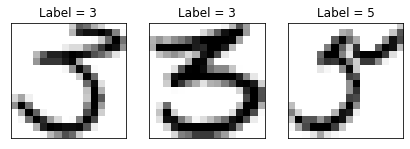

In [13]:
# Errors
fig = plt.figure(figsize=(12, 5))  # to specify the size of the images
t = np.where(y_pred!=y_test)[0]
for k, t_ in enumerate(t[:10]):
    fig.add_subplot(2, 5, k+1)
    mplot = plt.imshow(np.reshape(X_test[t_], (16, 16)), cmap="gray_r")
    plt.title("Label = {}".format(y_test[t_]))
    # hide the axis
    mplot.axes.get_xaxis().set_visible(False)
    mplot.axes.get_yaxis().set_visible(False)

#### Questions:
- Do you think that there is still room for improvement? Can we be more flexible than using a standard polynomial or RBF kernel?
- What about the computational time?
- *Optional:* redo the same operation for another pair of digits. Check if your results are still consistents.
- *Optional:* Run a kernel SVM for the original multiclass problem (using OVR strategy). Is the performance gain still as significant compared to LDA? Compared to QDA (using a small amount of regularization for QDA, e.g. `qda = QDA(reg_param=.1)`))?